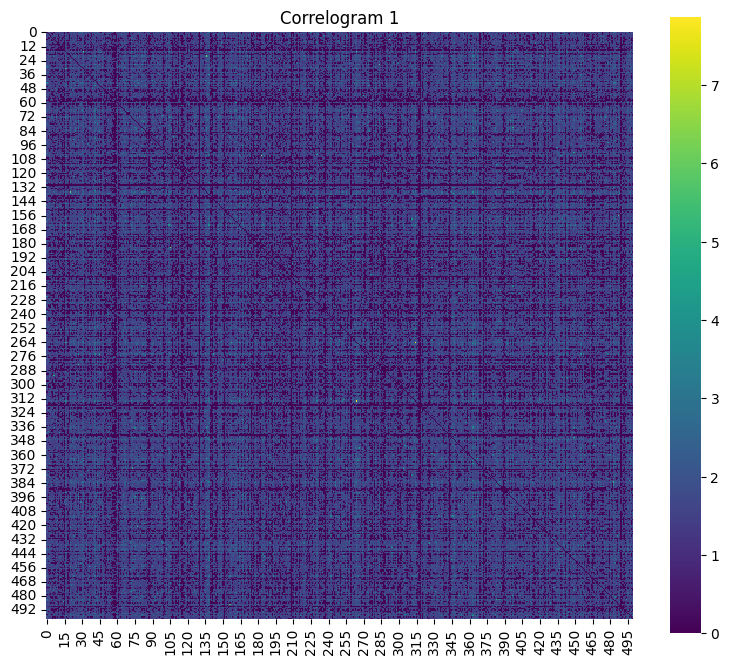

In [97]:
from utils.graphs.rgg import *
from utils.visuals import plot_matrices

def euclidean_sampler(n, d=10):
    return np.random.beta(2,5, [n, d])
    return np.random.uniform(0, 1, size=(n, d))

rgg_weighted = LatentSpaceRGG(
    latent_sampler=euclidean_sampler,
    distance_fn=euclidean_distance,
    connection_rule="radius",
    threshold=0.8,
    weight_fn=lambda d: 1 / (d + 1e-5)  # Avoid division by zero
)

plot_matrices(nx.adjacency_matrix(rgg_weighted.generate_graph(n=500)[0]).toarray())

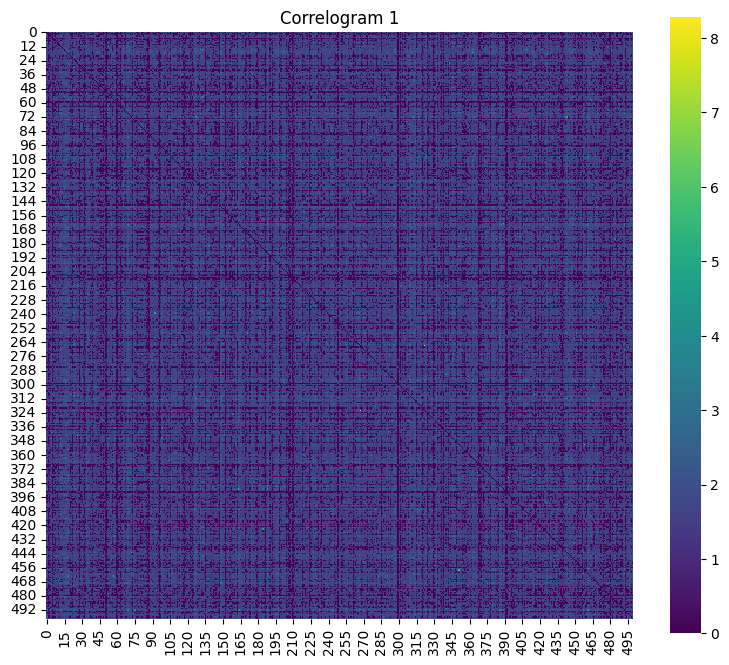

Epoch: 000, Loss: 1.3889, Rec Loss: 1.3889, KL Loss: 0.0160, AUC: 0.6373, AP: 0.5516
Epoch: 010, Loss: 1.3877, Rec Loss: 1.3873, KL Loss: 0.0020, AUC: 0.5281, AP: 0.4689
Epoch: 020, Loss: 1.3870, Rec Loss: 1.3868, KL Loss: 0.0008, AUC: 0.5497, AP: 0.4820
Epoch: 030, Loss: 1.3867, Rec Loss: 1.3866, KL Loss: 0.0003, AUC: 0.5356, AP: 0.4735
Epoch: 040, Loss: 1.3865, Rec Loss: 1.3865, KL Loss: 0.0003, AUC: 0.5403, AP: 0.4762
Epoch: 050, Loss: 1.3864, Rec Loss: 1.3864, KL Loss: 0.0002, AUC: 0.5321, AP: 0.4706
Epoch: 060, Loss: 1.3864, Rec Loss: 1.3864, KL Loss: 0.0002, AUC: 0.4764, AP: 0.4420
Epoch: 070, Loss: 1.3863, Rec Loss: 1.3863, KL Loss: 0.0002, AUC: 0.4721, AP: 0.4401
Epoch: 080, Loss: 1.3864, Rec Loss: 1.3864, KL Loss: 0.0002, AUC: 0.3943, AP: 0.4066
Epoch: 090, Loss: 1.3865, Rec Loss: 1.3864, KL Loss: 0.0002, AUC: 0.3107, AP: 0.3765
Epoch: 100, Loss: 1.3865, Rec Loss: 1.3864, KL Loss: 0.0002, AUC: 0.3977, AP: 0.4078
Epoch: 110, Loss: 1.3863, Rec Loss: 1.3862, KL Loss: 0.0002, AUC:

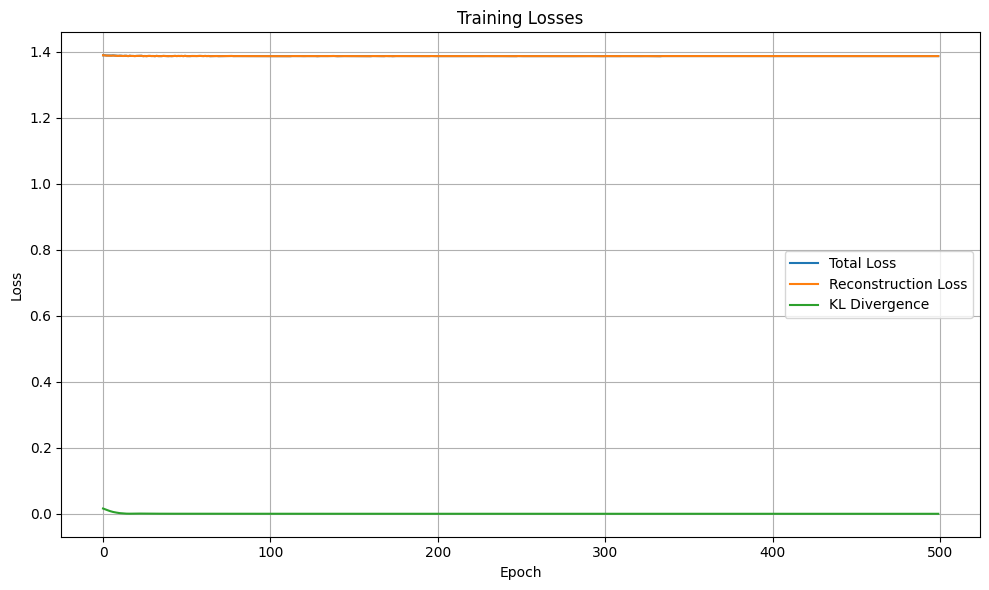

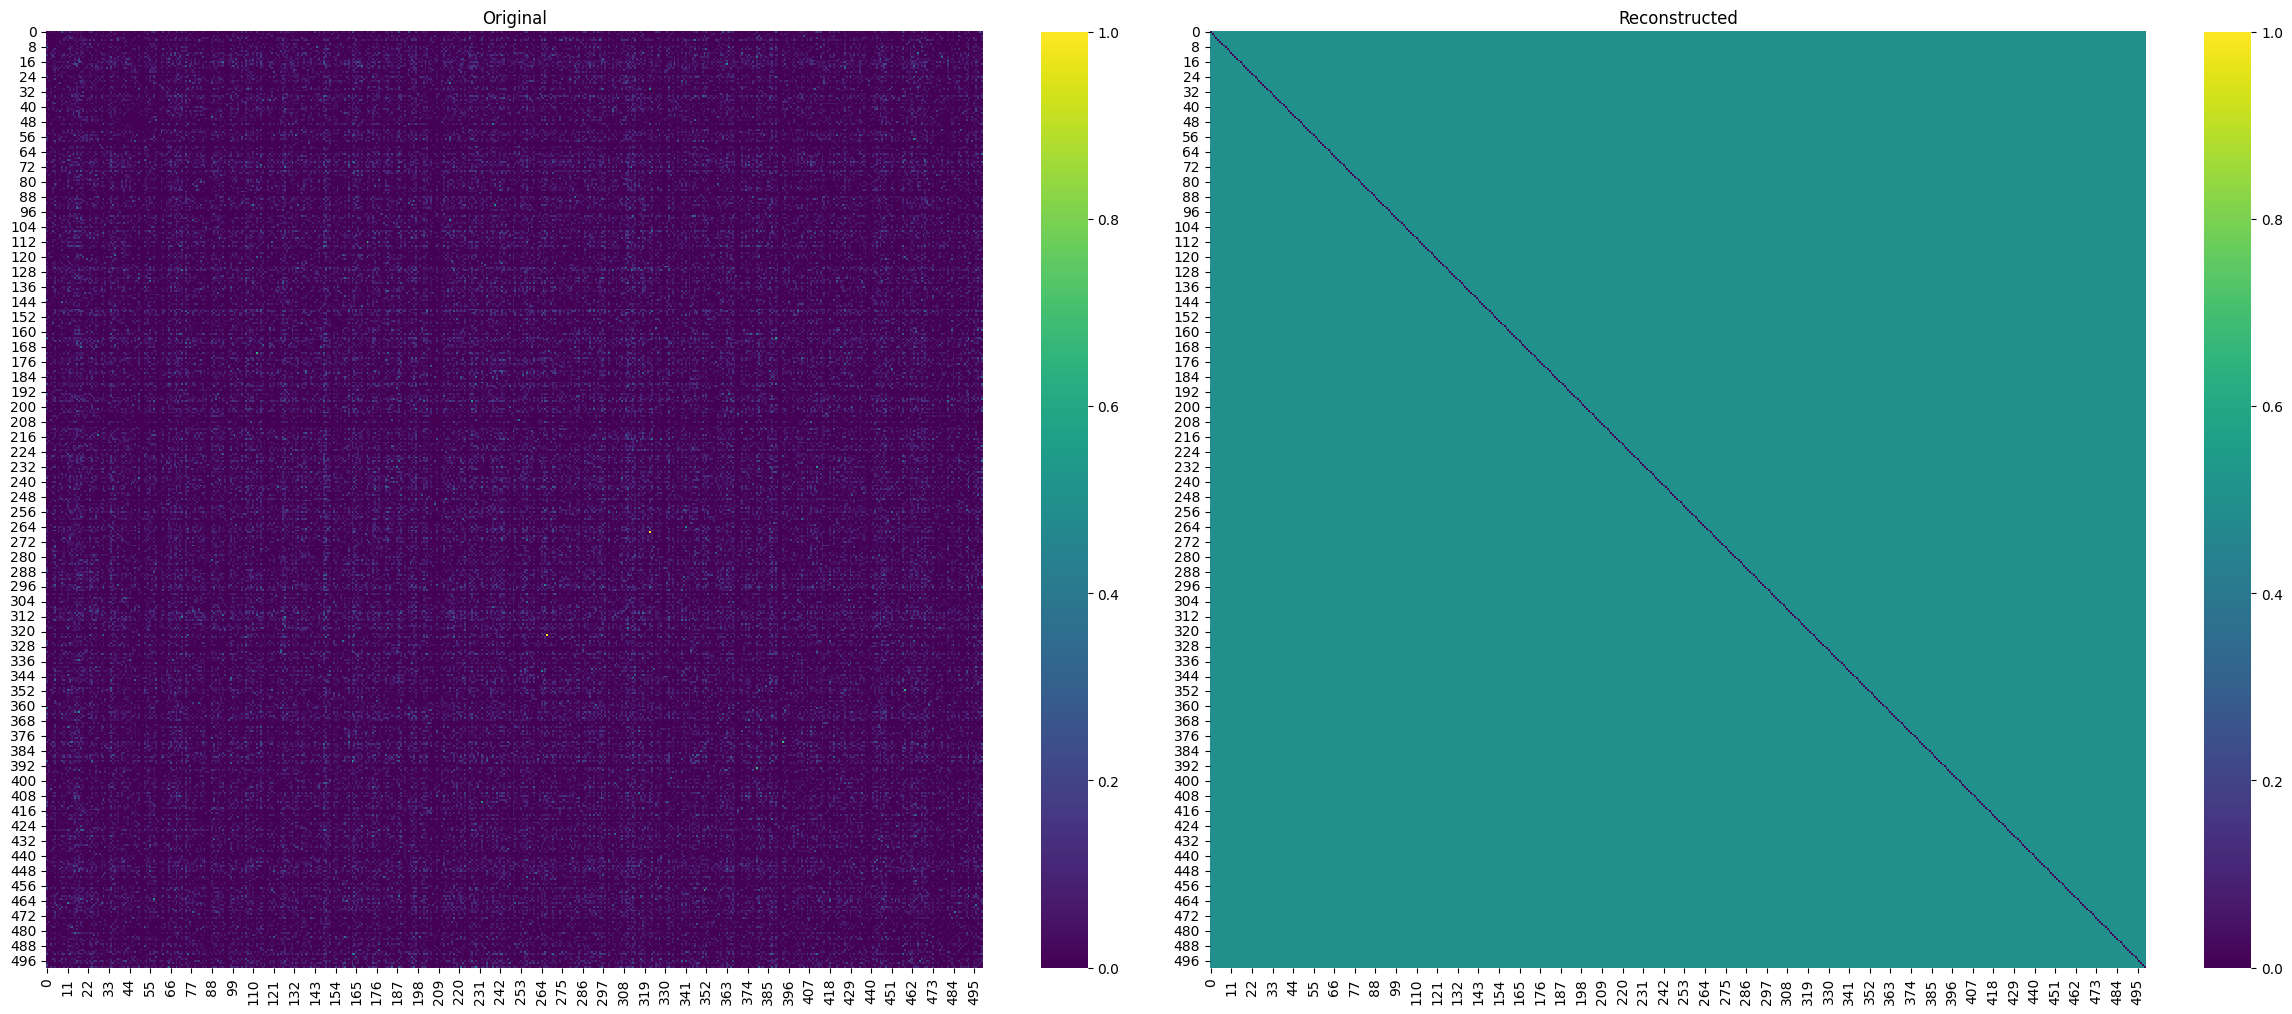

In [104]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.utils import negative_sampling, to_undirected, from_networkx
import scipy.sparse as sp

def build_dense_adjacency(edge_index, edge_attr, num_nodes):
    adj = torch.zeros((num_nodes, num_nodes))
    for i in range(edge_index.shape[1]):
        src, dst = edge_index[:, i]
        weight = edge_attr[i] if edge_attr is not None else 1.0
        adj[src, dst] = weight
        adj[dst, src] = weight  # Assuming undirected
    return adj

def reconstruct_adjacency(model, z):
    """Predict edge weights between all node pairs."""
    num_nodes = z.size(0)
    row, col = torch.triu_indices(num_nodes, num_nodes, offset=1)
    edge_index_all = torch.stack([row, col], dim=0).to(z.device)
    with torch.no_grad():
        pred_weights = model.decode(z, edge_index_all)
    
    pred_adj = torch.zeros((num_nodes, num_nodes)).to(z.device)
    pred_adj[row, col] = pred_weights
    pred_adj[col, row] = pred_weights  # symmetric
    return pred_adj.cpu()

class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim):
        super(GCNEncoder, self).__init__()
        self.conv1 = pyg_nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = pyg_nn.GCNConv(hidden_channels, hidden_channels)
        self.fc_mu = nn.Linear(hidden_channels, latent_dim)
        self.fc_var = nn.Linear(hidden_channels, latent_dim)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        return self.fc_mu(x), self.fc_var(x)

class MLPDecoder(nn.Module):
    """MLP decoder that doesn't use scalar products"""
    def __init__(self, latent_dim, hidden_dim):
        super(MLPDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        
    def forward(self, z, edge_index):
        # Extract node embeddings for the edges
        src, dst = edge_index
        z_src = z[src]
        z_dst = z[dst]
        
        # Concatenate source and destination embeddings
        z_edge = torch.cat([z_src, z_dst], dim=1)
        
        # Pass through MLP
        h = F.relu(self.fc1(z_edge))
        h = F.relu(self.fc2(h))
        return torch.sigmoid(self.fc3(h)).squeeze()

class GCNVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim, decoder_hidden_dim):
        super(GCNVAE, self).__init__()
        self.encoder = GCNEncoder(in_channels, hidden_channels, latent_dim)
        self.decoder = MLPDecoder(latent_dim, decoder_hidden_dim)
        self.latent_dim = latent_dim
        
    def encode(self, x, edge_index):
        mu, log_var = self.encoder(x, edge_index)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu
    
    def decode(self, z, edge_index):
        return self.decoder(z, edge_index)
    
    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var
    
def kl_annealing(epoch, total_epochs, max_beta=1.0, mode="linear"):
    if mode == "linear":
        return min(max_beta, epoch / (total_epochs * 0.3))  # 0 → 1 over 30% of training
    elif mode == "cyclical":
        cycle_length = total_epochs // 4
        phase = epoch % cycle_length
        return min(max_beta, phase / (cycle_length * 0.5))

def train_step(model, optimizer, data, neg_edge_index, epoch, epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    z, mu, log_var = model(data.x, data.edge_index)
    
    # Compute reconstruction loss for positive edges
    pos_pred = model.decode(z, data.edge_index)
    pos_loss = -torch.log(pos_pred + 1e-15).mean()
    
    # Compute reconstruction loss for negative edges
    neg_pred = model.decode(z, neg_edge_index)
    neg_loss = -torch.log(1 - neg_pred + 1e-15).mean()
    
    # Combined reconstruction loss
    rec_loss = pos_loss + neg_loss
    
    # KL divergence loss
    kl_loss = -0.5 * torch.mean(torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim=1))
    
    # Total loss with weighting
    loss = rec_loss + kl_annealing(epoch, epochs, max_beta=0.2, mode="cyclical") * kl_loss
    
    loss.backward()
    optimizer.step()
    
    return loss.item(), rec_loss.item(), kl_loss.item()

def test_link_prediction(model, data, test_pos_edge_index, test_neg_edge_index):
    model.eval()
    with torch.no_grad():
        z, _, _ = model(data.x, data.edge_index)
        
        pos_pred = model.decode(z, test_pos_edge_index)
        neg_pred = model.decode(z, test_neg_edge_index)
        
        pred = torch.cat([pos_pred, neg_pred], dim=0).cpu().numpy()
        true = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))], dim=0).cpu().numpy()
        
        auc = roc_auc_score(true, pred)
        ap = average_precision_score(true, pred)
        
    return auc, ap

def prepare_data(graph, latent_features, device, use_random_features=True):
    # Extract edges and weights
    edge_list = list(graph.edges)
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # Extract weights or default to 1.0
    edge_weight = torch.tensor(
        [graph[u][v].get('weight', 1.0) for u, v in edge_list],
        dtype=torch.float
    )
    
    # Normalize edge weights to [0, 1]
    if edge_weight.numel() > 0:
        min_w = edge_weight.min()
        max_w = edge_weight.max()
        if max_w > min_w:
            edge_weight = (edge_weight - min_w) / (max_w - min_w)
        else:
            edge_weight = torch.ones_like(edge_weight)  # fallback if all weights are equal
    
    # Make undirected and duplicate weights accordingly
    edge_index, edge_weight = to_undirected(edge_index, edge_attr=edge_weight)

    # Node features
    num_nodes = graph.number_of_nodes()
    if use_random_features:
        num_features = latent_features.shape[1]
        x = torch.rand((num_nodes, num_features), dtype=torch.float)
    else:
        x = torch.tensor(latent_features, dtype=torch.float)

    # Build PyG data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)

    # Split into train/test edges (undirected => even count)
    num_edges = edge_index.size(1) // 2
    perm = torch.randperm(num_edges)

    train_idx = perm[:int(0.8 * num_edges)]
    test_idx = perm[int(0.8 * num_edges):]

    # Each edge appears twice (u,v) and (v,u), so take both
    train_edges = edge_index[:, 2 * train_idx]
    train_weights = edge_weight[2 * train_idx]

    test_pos_edges = edge_index[:, 2 * test_idx]
    test_weights = edge_weight[2 * test_idx]

    # Assign edge splits
    data.train_pos_edge_index = train_edges
    data.train_edge_weight = train_weights
    data.test_pos_edge_index = test_pos_edges
    data.test_edge_weight = test_weights

    # Negative sampling for evaluation
    data.test_neg_edge_index = negative_sampling(
        edge_index=edge_index,
        num_nodes=num_nodes,
        num_neg_samples=test_pos_edges.size(1)
    )

    # Override the working edge_index with only training data
    data.edge_index = data.train_pos_edge_index
    data.edge_attr = data.train_edge_weight

    return data.to(device)

def generate_negative_edges(edge_index, num_nodes, num_neg_samples):
    neg_edge_index = negative_sampling(
        edge_index=edge_index,
        num_nodes=num_nodes,
        num_neg_samples=num_neg_samples
    )
    return neg_edge_index

def visualize_embeddings(z, graph, save_path=None):
    plt.figure(figsize=(10, 8))
    
    # Use t-SNE if dimensionality is high
    if z.shape[1] > 2:
        from sklearn.manifold import TSNE
        z_np = z.detach().cpu().numpy()
        perplexity = min(30, max(5, (z_np.shape[0] - 1) // 3))  # safe perplexity
        z_embedded = TSNE(n_components=2, perplexity=perplexity).fit_transform(z.detach().cpu().numpy())
    else:
        z_embedded = z.detach().cpu().numpy()
    
    # Get node positions
    pos = {}
    for i in range(len(z_embedded)):
        pos[i] = (z_embedded[i, 0], z_embedded[i, 1])
    
    # Draw the graph
    nx.draw_networkx(graph, pos=pos, with_labels=True, node_color='lightblue', 
                     node_size=500, edge_color='gray', width=1, alpha=0.7)
    
    if save_path:
        plt.savefig(save_path)
    plt.show()

def main():
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Generate a single graph
    graph, latent = rgg_weighted.generate_graph(n=500)
    plot_matrices(nx.adjacency_matrix(graph).toarray())
    
    # Prepare data
    data = prepare_data(graph, latent, device)
    
    # Model parameters
    in_channels = latent.shape[1]  # Number of input features
    hidden_channels = 64
    latent_dim = 2  # Dimensionality of the latent space
    decoder_hidden_dim = 32
    lr = 0.001
    epochs = 500
    
    # Initialize model
    model = GCNVAE(in_channels, hidden_channels, latent_dim, decoder_hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    best_auc = 0
    total_losses, rec_losses, kl_losses = [], [], []
    for epoch in range(epochs):
        # Generate negative edges for training
        neg_edge_index = generate_negative_edges(data.edge_index, data.x.size(0), data.edge_index.size(1))
        
        # Train step
        loss, rec_loss, kl_loss = train_step(model, optimizer, data, neg_edge_index, epoch, epochs)
        total_losses.append(loss)
        rec_losses.append(rec_loss)
        kl_losses.append(kl_loss)
        
        # Evaluation
        if epoch % 10 == 0:
            auc, ap = test_link_prediction(model, data, data.test_pos_edge_index, data.test_neg_edge_index)
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Rec Loss: {rec_loss:.4f}, '
                  f'KL Loss: {kl_loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}')
            
            if auc > best_auc:
                best_auc = auc
                # Save model or embeddings if needed
                # torch.save(model.state_dict(), 'best_model.pt')
                
                # Get node embeddings
                z, _, _ = model(data.x, data.edge_index)
                
                # Visualize embeddings
                #visualize_embeddings(z, graph, save_path=None)
    
    # Final evaluation
    auc, ap = test_link_prediction(model, data, data.test_pos_edge_index, data.test_neg_edge_index)
    print(f'Final AUC: {auc:.4f}, AP: {ap:.4f}')
    
    # Get final embeddings
    z, _, _ = model(data.x, data.edge_index)
    print(f'Latent embeddings shape: {z.shape}')

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(total_losses, label='Total Loss')
    plt.plot(rec_losses, label='Reconstruction Loss')
    plt.plot(kl_losses, label='KL Divergence')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Losses")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Reconstruct adjacency matrix

    with torch.no_grad():
        # Original adjacency (with weights)
        true_adj = build_dense_adjacency(data.edge_index, 
                                        edge_attr=data.edge_attr,  # or actual weights if available
                                        num_nodes=data.num_nodes).cpu().numpy()

        # Reconstructed adjacency
        pred_adj = reconstruct_adjacency(model, z).numpy()

        # Plot
        plot_matrices(true_adj, pred_adj, titles=["Original", "Reconstructed"])

    
    return model, z, data

if __name__ == "__main__":
    model, embeddings, data = main()

# Example for training on multiple graphs
def train_on_multiple_graphs():
    # Generate multiple graphs
    graphs, latent_list = rgg_weighted.generate_graphs(num_graphs=1000, n=200)
    
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Model parameters
    in_channels = latent_list[0].shape[1]  # Number of input features
    hidden_channels = 64
    latent_dim = 16
    decoder_hidden_dim = 32
    lr = 0.01
    epochs = 50
    
    # Initialize model
    model = GCNVAE(in_channels, hidden_channels, latent_dim, decoder_hidden_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Training loop
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_rec_loss = 0
        epoch_kl_loss = 0
        
        for i, (graph, latent) in enumerate(zip(graphs, latent_list)):
            # Prepare data for this graph
            data = prepare_data(graph, latent, device)
            
            # Generate negative edges for training
            neg_edge_index = generate_negative_edges(data.edge_index, data.x.size(0), data.edge_index.size(1))
            
            # Train step
            loss, rec_loss, kl_loss = train_step(model, optimizer, data, neg_edge_index)
            
            epoch_loss += loss
            epoch_rec_loss += rec_loss
            epoch_kl_loss += kl_loss
            
            # Print progress
            if (i + 1) % 100 == 0:
                print(f'Epoch: {epoch:03d}, Batch: {i+1}/{len(graphs)}, '
                      f'Loss: {epoch_loss/(i+1):.4f}')
        
        # Average loss over all graphs
        avg_loss = epoch_loss / len(graphs)
        avg_rec_loss = epoch_rec_loss / len(graphs)
        avg_kl_loss = epoch_kl_loss / len(graphs)
        
        print(f'Epoch: {epoch:03d}, Avg Loss: {avg_loss:.4f}, '
              f'Avg Rec Loss: {avg_rec_loss:.4f}, Avg KL Loss: {avg_kl_loss:.4f}')
    
    return model

Epoch 20/300, Loss: 1.6956, Recon Adj: 0.5397, Recon Feat: 1.0007, KL: 0.3062, Beta: 0.5067, Edge Acc: 0.7771, Edge Feat MSE: 1.0007
Epoch 40/300, Loss: 1.5500, Recon Adj: 0.5339, Recon Feat: 1.0010, KL: 0.0151, Beta: 1.0000, Edge Acc: 0.7771, Edge Feat MSE: 1.0010
Epoch 60/300, Loss: 1.5374, Recon Adj: 0.5351, Recon Feat: 0.9998, KL: 0.0024, Beta: 1.0000, Edge Acc: 0.7771, Edge Feat MSE: 0.9998
Epoch 80/300, Loss: 1.5337, Recon Adj: 0.5327, Recon Feat: 1.0005, KL: 0.0036, Beta: 0.1067, Edge Acc: 0.7771, Edge Feat MSE: 1.0005
Epoch 100/300, Loss: 1.5316, Recon Adj: 0.5309, Recon Feat: 1.0006, KL: 0.0002, Beta: 0.6400, Edge Acc: 0.7771, Edge Feat MSE: 1.0006
Epoch 120/300, Loss: 1.5320, Recon Adj: 0.5319, Recon Feat: 1.0001, KL: 0.0000, Beta: 1.0000, Edge Acc: 0.7771, Edge Feat MSE: 1.0001
Epoch 140/300, Loss: 1.5303, Recon Adj: 0.5299, Recon Feat: 1.0004, KL: 0.0000, Beta: 1.0000, Edge Acc: 0.7771, Edge Feat MSE: 1.0004
Epoch 160/300, Loss: 1.5346, Recon Adj: 0.5341, Recon Feat: 1.0005

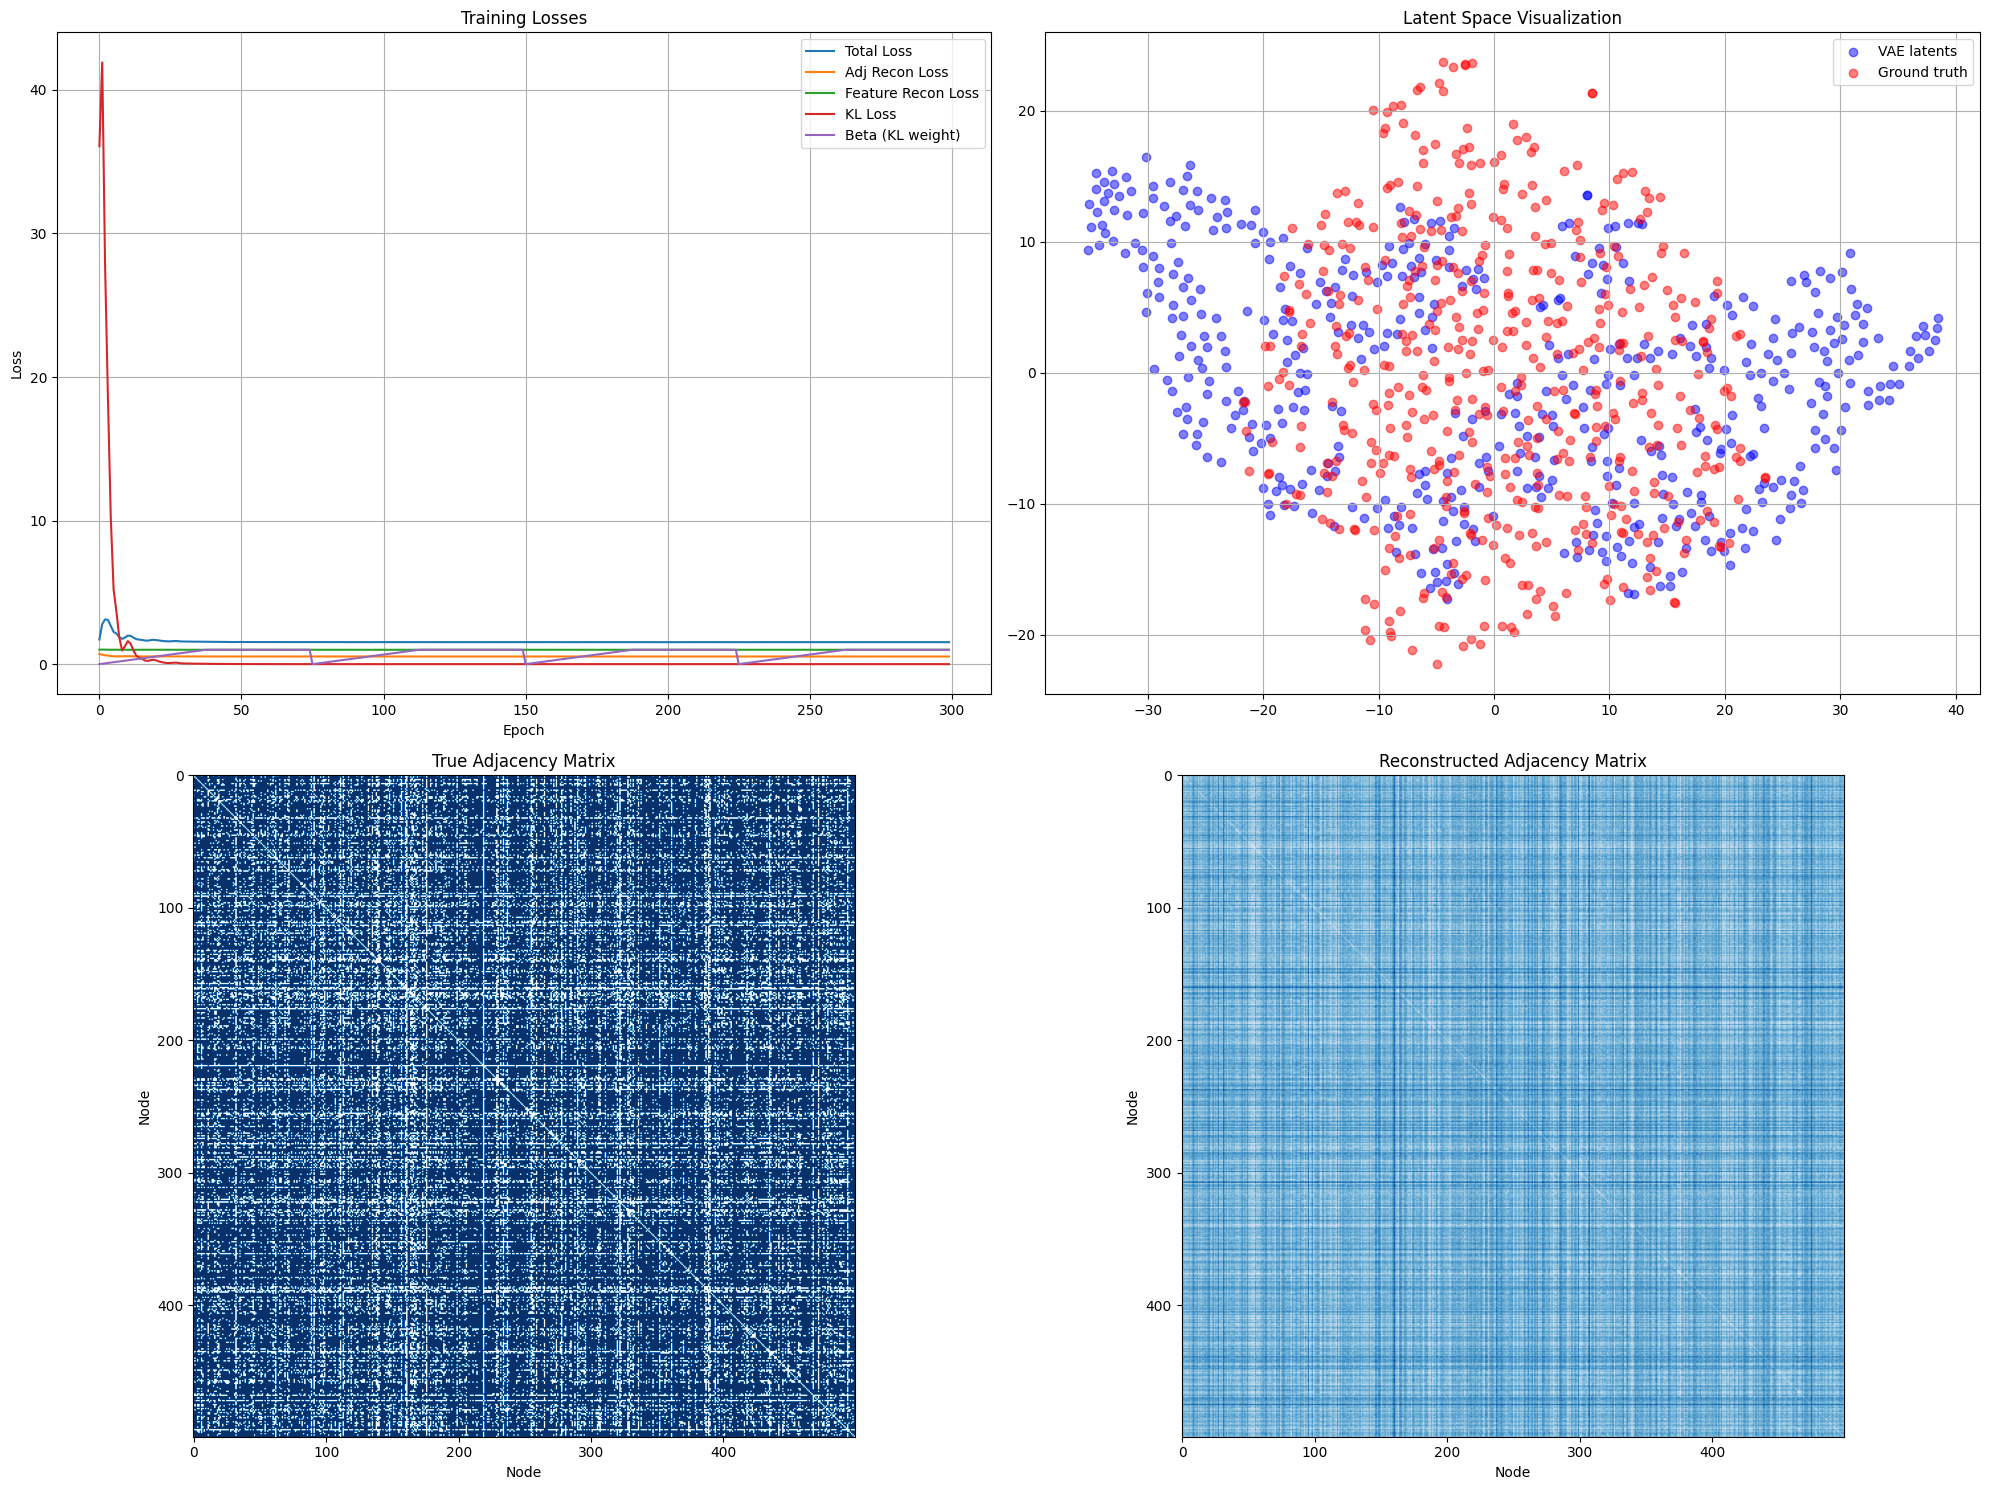

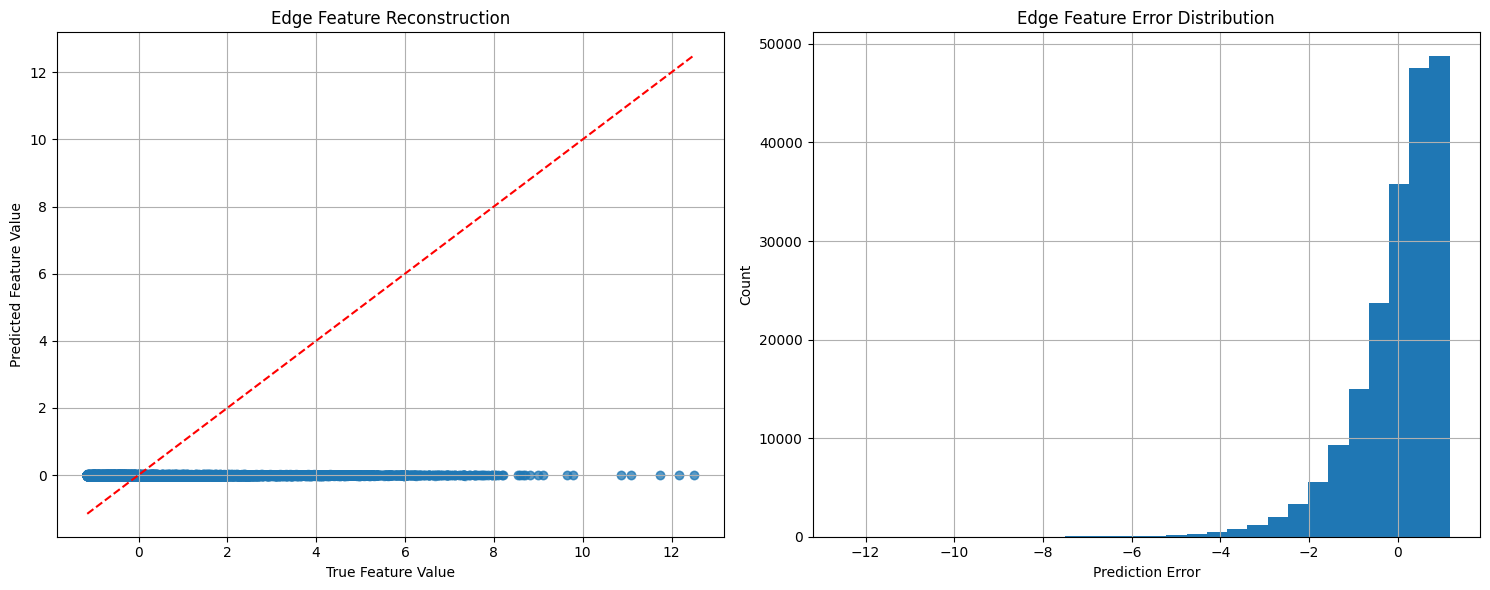

In [108]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx, to_dense_adj
from sklearn.manifold import TSNE
import random

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class MLPDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, edge_feature_dim=1):
        super(MLPDecoder, self).__init__()
        # MLP to predict edge existence and features
        self.edge_predictor = nn.Sequential(
            nn.Linear(latent_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1 + edge_feature_dim)  # +1 for edge existence
        )
        self.edge_feature_dim = edge_feature_dim
        
    def forward(self, z):
        # z has shape [num_nodes, latent_dim]
        num_nodes = z.size(0)
        
        # Create node pairs for all possible edges
        node_i = torch.repeat_interleave(torch.arange(num_nodes), num_nodes)
        node_j = torch.tile(torch.arange(num_nodes), (num_nodes,))
        
        # Get latent representations for each node pair
        z_i = z[node_i]
        z_j = z[node_j]
        
        # Concatenate node pair embeddings
        z_pairs = torch.cat([z_i, z_j], dim=1)
        
        # Predict edge existence and features
        out = self.edge_predictor(z_pairs)
        
        # Reshape to adjacency matrix format
        edge_logits = out[:, 0].view(num_nodes, num_nodes)  # Edge existence logits
        
        if self.edge_feature_dim > 0:
            edge_features = out[:, 1:].view(num_nodes, num_nodes, self.edge_feature_dim)
            return edge_logits, edge_features
        
        return edge_logits, None

class GCNVAE(nn.Module):
    def __init__(self, num_features, hidden_dim, latent_dim, edge_feature_dim=1):
        super(GCNVAE, self).__init__()
        
        # Encoder
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # Latent space projections
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.log_var = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = MLPDecoder(latent_dim, hidden_dim, edge_feature_dim)
        
        self.latent_dim = latent_dim
        self.edge_feature_dim = edge_feature_dim
    
    def encode(self, x, edge_index):
        # Graph convolution layers
        h = F.relu(self.conv1(x, edge_index))
        h = F.relu(self.conv2(h, edge_index))
        
        # Project to latent parameters
        mu = self.mu(h)
        log_var = self.log_var(h)
        
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        # Reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        # Decode latent space to adjacency matrix and edge features
        return self.decoder(z)
    
    def forward(self, x, edge_index):
        # Encode
        mu, log_var = self.encode(x, edge_index)
        
        # Sample latent variables
        z = self.reparameterize(mu, log_var)
        
        # Decode
        adj_logits, edge_features = self.decode(z)
        
        return adj_logits, edge_features, mu, log_var

def get_edge_accuracy(pred_adj, true_adj, threshold=0.5):
    """Calculate edge prediction accuracy"""
    pred_edges = (torch.sigmoid(pred_adj) > threshold).float()
    correct = (pred_edges == true_adj).sum().item()
    total = true_adj.numel()
    return correct / total

def get_edge_feature_mse(pred_features, true_features, edge_mask):
    """Calculate MSE for edge features on existing edges"""
    if pred_features is None or true_features is None:
        return 0.0
    
    # Only consider features on existing edges
    mse = F.mse_loss(pred_features[edge_mask], true_features[edge_mask])
    return mse.item()

def kl_annealing(epoch, total_epochs, max_beta=1.0, mode="linear"):
    if mode == "linear":
        return min(max_beta, epoch / (total_epochs * 0.3))  # 0 → 1 over 30% of training
    elif mode == "cyclical":
        cycle_length = total_epochs // 4
        phase = epoch % cycle_length
        return min(max_beta, phase / (cycle_length * 0.5))
    else:
        return max_beta

def train_vae(model, graph, edge_features, optimizer, num_epochs=300, annealing_mode="cyclical"):
    # Convert NetworkX graph to PyTorch Geometric format
    pyg_data = from_networkx(graph)
    
    # Number of nodes
    num_nodes = graph.number_of_nodes()
    
    # Create node features (in this case, just one-hot node indices)
    node_features = torch.eye(num_nodes)
    
    # Get edge indices
    edge_index = pyg_data.edge_index
    
    # Create adjacency matrix
    adj_matrix = to_dense_adj(edge_index)[0]
    
    # Set up tracking for losses
    losses = {
        'total': [],
        'recon_adj': [],
        'recon_feat': [],
        'kl': [],
        'beta': []
    }

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        adj_logits, pred_edge_features, mu, log_var = model(node_features, edge_index)
        
        # Calculate reconstruction loss for adjacency
        recon_loss_adj = F.binary_cross_entropy_with_logits(adj_logits, adj_matrix)
        
        # Calculate reconstruction loss for edge features if they exist
        if edge_features is not None and pred_edge_features is not None:
            # Only compute loss for existing edges
            edge_mask = adj_matrix == 1
            recon_loss_feat = F.mse_loss(pred_edge_features[edge_mask], edge_features[edge_mask])
        else:
            recon_loss_feat = torch.tensor(0.0)
        
        # KL divergence
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Apply KL annealing
        beta = kl_annealing(epoch, num_epochs, mode=annealing_mode)
        
        # Total loss
        loss = recon_loss_adj + recon_loss_feat + beta * kl_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Record losses
        losses['total'].append(loss.item())
        losses['recon_adj'].append(recon_loss_adj.item())
        losses['recon_feat'].append(recon_loss_feat.item() if isinstance(recon_loss_feat, torch.Tensor) else 0)
        losses['kl'].append(kl_loss.item())
        losses['beta'].append(beta)
        
        # Calculate metrics
        edge_acc = get_edge_accuracy(adj_logits, adj_matrix)
        edge_feat_mse = get_edge_feature_mse(pred_edge_features, edge_features, adj_matrix == 1)
        
        # Print progress
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, "
                  f"Recon Adj: {recon_loss_adj.item():.4f}, "
                  f"Recon Feat: {recon_loss_feat.item() if isinstance(recon_loss_feat, torch.Tensor) else 0:.4f}, "
                  f"KL: {kl_loss.item():.4f}, "
                  f"Beta: {beta:.4f}, "
                  f"Edge Acc: {edge_acc:.4f}, "
                  f"Edge Feat MSE: {edge_feat_mse:.4f}")
    
    return model, losses

def visualize_results(model, graph, edge_features, losses, latent_ground_truth=None):
    """Visualize VAE results including loss curves, latent space and adjacency comparison"""
    model.eval()
    
    # Convert to PyG format
    pyg_data = from_networkx(graph)
    num_nodes = graph.number_of_nodes()
    node_features = torch.eye(num_nodes)
    edge_index = pyg_data.edge_index
    true_adj = to_dense_adj(edge_index)[0]
    
    # Get model outputs
    with torch.no_grad():
        adj_logits, pred_edge_features, mu, _ = model(node_features, edge_index)
        pred_adj = torch.sigmoid(adj_logits)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Plot loss curves
    ax1 = fig.add_subplot(2, 2, 1)
    epochs = range(len(losses['total']))
    ax1.plot(epochs, losses['total'], label='Total Loss')
    ax1.plot(epochs, losses['recon_adj'], label='Adj Recon Loss')
    ax1.plot(epochs, losses['recon_feat'], label='Feature Recon Loss')
    ax1.plot(epochs, losses['kl'], label='KL Loss')
    ax1.plot(epochs, losses['beta'], label='Beta (KL weight)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Losses')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Plot latent space (using t-SNE for visualization if dims > 2)
    ax2 = fig.add_subplot(2, 2, 2)
    
    # Convert to numpy for visualization
    latent_z = mu.detach().numpy()
    
    # Apply t-SNE if latent dimension > 2
    if latent_z.shape[1] > 2:
        latent_viz = TSNE(n_components=2).fit_transform(latent_z)
    else:
        latent_viz = latent_z
    
    # Plot VAE latent space
    ax2.scatter(latent_viz[:, 0], latent_viz[:, 1], c='blue', alpha=0.5, label='VAE latents')
    
    # If ground truth latents are provided, plot those too
    if latent_ground_truth is not None:
        # Apply the same dimensionality reduction if needed
        if latent_ground_truth.shape[1] > 2:
            gt_viz = TSNE(n_components=2).fit_transform(latent_ground_truth)
        else:
            gt_viz = latent_ground_truth
            
        ax2.scatter(gt_viz[:, 0], gt_viz[:, 1], c='red', alpha=0.5, label='Ground truth')
    
    ax2.set_title('Latent Space Visualization')
    ax2.legend()
    ax2.grid(True)
    
    # 3. Plot true adjacency matrix
    ax3 = fig.add_subplot(2, 2, 3)
    ax3.imshow(true_adj.numpy(), cmap='Blues')
    ax3.set_title('True Adjacency Matrix')
    ax3.set_xlabel('Node')
    ax3.set_ylabel('Node')
    
    # 4. Plot reconstructed adjacency matrix
    ax4 = fig.add_subplot(2, 2, 4)
    ax4.imshow(pred_adj.numpy(), cmap='Blues')
    ax4.set_title('Reconstructed Adjacency Matrix')
    ax4.set_xlabel('Node')
    ax4.set_ylabel('Node')
    
    plt.tight_layout()
    plt.savefig('gcn_vae_results.png')
    plt.show()
    
    # If edge features exist, also visualize feature reconstruction
    if edge_features is not None and pred_edge_features is not None:
        # Plot heatmap of true vs predicted features for a sample of edges
        edge_mask = true_adj == 1
        true_features = edge_features[edge_mask].detach().numpy()
        pred_features = pred_edge_features[edge_mask].detach().numpy()
        
        # Sample up to 100 edges for visualization
        sample_size = min(100, true_features.shape[0])
        indices = np.random.choice(true_features.shape[0], sample_size, replace=False)
        
        # Create figure for feature comparison
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
        
        # For scalar features
        if true_features.shape[1] == 1:
            # Reshape to 1D arrays
            true_flat = true_features.flatten()
            pred_flat = pred_features.flatten()
            
            # Plot correlation
            axs[0].scatter(true_flat, pred_flat, alpha=0.5)
            axs[0].plot([min(true_flat), max(true_flat)], [min(true_flat), max(true_flat)], 'r--')
            axs[0].set_xlabel('True Feature Value')
            axs[0].set_ylabel('Predicted Feature Value')
            axs[0].set_title('Edge Feature Reconstruction')
            axs[0].grid(True)
            
            # Plot histogram of errors
            errors = pred_flat - true_flat
            axs[1].hist(errors, bins=30)
            axs[1].set_xlabel('Prediction Error')
            axs[1].set_ylabel('Count')
            axs[1].set_title('Edge Feature Error Distribution')
            axs[1].grid(True)
        
        # For vector features
        else:
            # Sample some edges
            true_sample = true_features[indices]
            pred_sample = pred_features[indices]
            
            # Plot heatmaps
            im1 = axs[0].imshow(true_sample, aspect='auto')
            axs[0].set_title('True Edge Features')
            axs[0].set_xlabel('Feature Dimension')
            axs[0].set_ylabel('Edge Index')
            plt.colorbar(im1, ax=axs[0])
            
            im2 = axs[1].imshow(pred_sample, aspect='auto')
            axs[1].set_title('Predicted Edge Features')
            axs[1].set_xlabel('Feature Dimension')
            axs[1].set_ylabel('Edge Index')
            plt.colorbar(im2, ax=axs[1])
        
        plt.tight_layout()
        plt.savefig('edge_feature_reconstruction.png')
        plt.show()

def generate_random_edge_features(graph, feature_dim=1):
    """
    Generate random edge features for the graph.
    If feature_dim is 1, the features are normalized (z-score).
    """
    num_nodes = graph.number_of_nodes()
    # Create a tensor of zeros for all possible edges
    edge_features = torch.zeros(num_nodes, num_nodes, feature_dim)

    # Fill in random values for actual edges
    # Ensure adj_matrix is handled as a numpy array before converting to torch tensor for mask
    adj_matrix = nx.to_numpy_array(graph)
    # Create a boolean mask for existing edges
    edge_mask = torch.tensor(adj_matrix > 0, dtype=torch.bool)

    # Generate random features for existing edges
    if feature_dim == 1:
        # For scalar features, use the edge weight or a random value
        # Generate initial features based on weights or random values
        # This part can be vectorized for efficiency instead of nested loops
        # Create a temporary tensor for initial features
        initial_features = torch.zeros(num_nodes, num_nodes, feature_dim)
        for i in range(num_nodes):
            for j in range(num_nodes):
                if edge_mask[i, j]:
                    initial_features[i, j, 0] = graph[i][j].get('weight', torch.rand(1).item())

        # Extract only the features for existing edges that need normalization
        existing_edge_features = initial_features[edge_mask].view(-1, 1)

        if existing_edge_features.numel() > 0:
            # Calculate mean and standard deviation
            mean = existing_edge_features.mean()
            std = existing_edge_features.std()

            # Apply normalization (z-score normalization)
            # Avoid division by zero if std is 0
            if std > 1e-5:
                normalized_edge_features = (existing_edge_features - mean) / std
            else:
                # If std is 0, features are constant, set to 0 after centering
                normalized_edge_features = existing_edge_features - mean

            # Place the normalized features back into the original tensor structure
            # Create a new tensor to hold the normalized features with the original shape
            normalized_edge_features_full = torch.zeros_like(edge_features)
            # Fix: Assign the normalized features with shape [N, 1] directly
            normalized_edge_features_full[edge_mask] = normalized_edge_features
            edge_features = normalized_edge_features_full
        # If no existing edges, edge_features remains all zeros, which is correct.

    else:
        # For vector features, generate random values only for existing edges
        # Generate random features for all potential edges first
        random_features = torch.rand(num_nodes, num_nodes, feature_dim)
        # Use the mask to keep only features for existing edges
        # Expand mask for broadcasting across the feature dimension
        edge_features = random_features * edge_mask.unsqueeze(-1)

    return edge_features

def main(n=500, edge_feature_dim=1, latent_dim=16, hidden_dim=64, num_epochs=300):
     # Try to import and use the provided generator
    graph, latent = rgg_weighted.generate_graph(n=n)
    # Convert latent positions to torch tensor if needed
    latent = torch.tensor(latent) if isinstance(latent, np.ndarray) else latent
    
    # Generate random edge features
    edge_features = generate_random_edge_features(graph, feature_dim=edge_feature_dim)
    
    # Initialize model
    model = GCNVAE(
        num_features=n,  # One-hot encoding of node IDs
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        edge_feature_dim=edge_feature_dim
    )
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    trained_model, losses = train_vae(
        model, 
        graph, 
        edge_features, 
        optimizer, 
        num_epochs=num_epochs,
        annealing_mode="cyclical"  # Use cyclical KL annealing
    )
    
    # Visualize results
    visualize_results(trained_model, graph, edge_features, losses, latent_ground_truth=latent)
    
    return trained_model, graph, edge_features, losses

if __name__ == "__main__":
    main(n=500, edge_feature_dim=1, latent_dim=16, hidden_dim=64, num_epochs=300)

Using device: cpu
Generating graph...
Generated mock graph with 100 nodes and 556 edges.
Preparing data...
No node features provided. Generating random features (dim=16).
Data prepared: Data(x=[100, 16], edge_index=[2, 1112], edge_attr=[1112, 1])

--- Starting Training ---
Model: GCNVAE(
  (encoder): GCNEncoder(
    (conv1): GCNConv(16, 32)
    (conv2): GCNConv(32, 32)
    (fc_mu): Linear(in_features=32, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): MLPDecoder(
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): ReLU()
    )
    (fc_adj): Linear(in_features=32, out_features=1, bias=True)
    (fc_feat): Linear(in_features=32, out_features=1, bias=True)
  )
)
Number of nodes: 100
Epochs: 200
Learning rate: 0.01
KL Annealing: cyclical, Max Beta: 0.1
Epoch 010/200 | Total Loss: 1.4150 | Adj Loss: 1.309

/var/folders/qc/fbm2wz190nqd87d2mq7l90_80000gn/T/ipykernel_38909/1498390002.py:291: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_weight = torch.tensor(adj_target.numel() / adj_target.sum() - 1.0, device=adj_target.device) # Calculate pos_weight dynamically


Epoch 050/200 | Total Loss: 1.3947 | Adj Loss: 1.3101 | Feat Loss: 0.0845 | KL Loss: 0.0006 | Beta: 0.000
Epoch 060/200 | Total Loss: 1.3923 | Adj Loss: 1.3095 | Feat Loss: 0.0828 | KL Loss: 0.0012 | Beta: 0.040
Epoch 070/200 | Total Loss: 1.3922 | Adj Loss: 1.3101 | Feat Loss: 0.0821 | KL Loss: 0.0004 | Beta: 0.080
Epoch 080/200 | Total Loss: 1.3931 | Adj Loss: 1.3103 | Feat Loss: 0.0828 | KL Loss: 0.0003 | Beta: 0.100
Epoch 090/200 | Total Loss: 1.3928 | Adj Loss: 1.3099 | Feat Loss: 0.0829 | KL Loss: 0.0002 | Beta: 0.100
Epoch 100/200 | Total Loss: 1.3945 | Adj Loss: 1.3103 | Feat Loss: 0.0842 | KL Loss: 0.0003 | Beta: 0.000
Epoch 110/200 | Total Loss: 1.3924 | Adj Loss: 1.3103 | Feat Loss: 0.0820 | KL Loss: 0.0009 | Beta: 0.040
Epoch 120/200 | Total Loss: 1.3926 | Adj Loss: 1.3107 | Feat Loss: 0.0819 | KL Loss: 0.0006 | Beta: 0.080
Epoch 130/200 | Total Loss: 1.3930 | Adj Loss: 1.3106 | Feat Loss: 0.0823 | KL Loss: 0.0003 | Beta: 0.100
Epoch 140/200 | Total Loss: 1.3919 | Adj Loss:

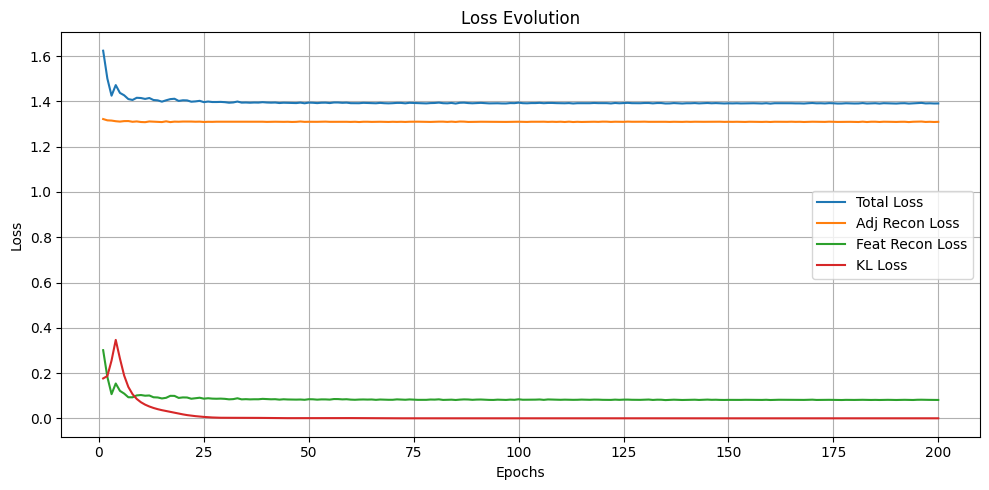

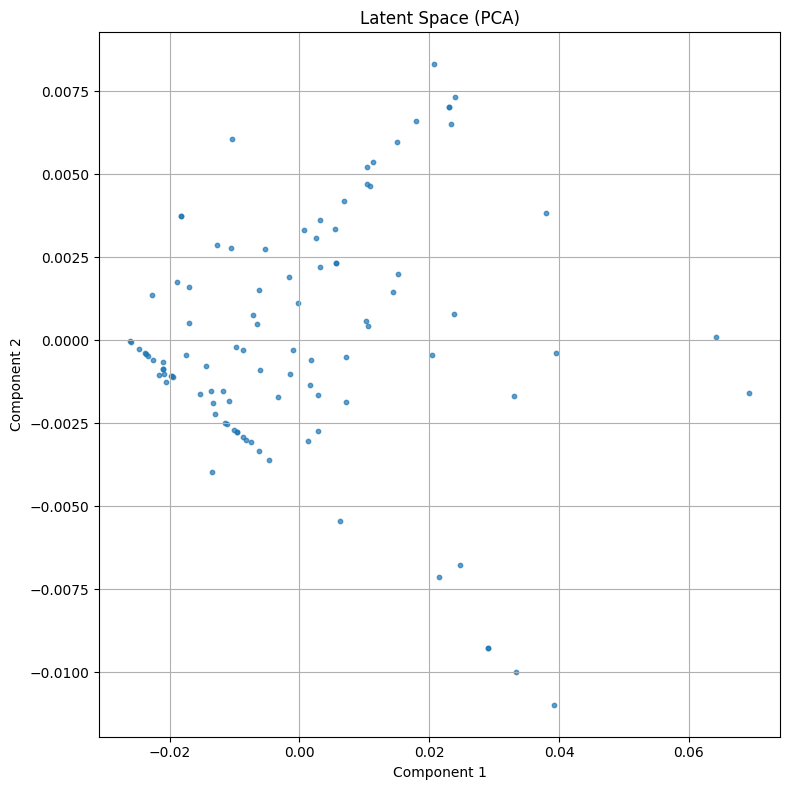

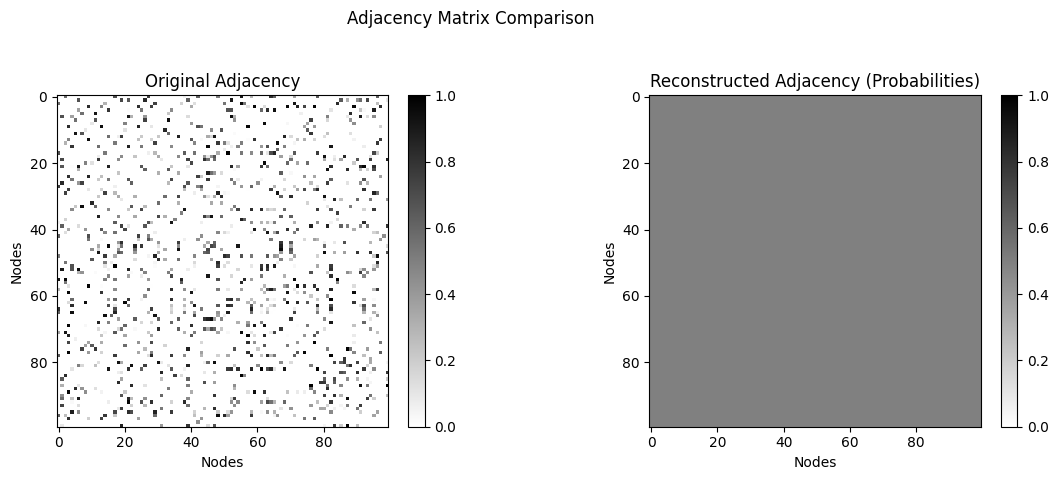


Done.


In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx, from_networkx, negative_sampling
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random
import time

# --- Configuration ---
N_NODES = 100 # Reduced from 500 for faster demonstration
NODE_FEATURE_DIM = 16 # Dimension for random node features if none provided
EDGE_FEATURE_DIM = 1 # Dimension of edge features (1 for scalar, >1 for vector)
HIDDEN_DIM = 32
LATENT_DIM = 16
EPOCHS = 200 # Number of training epochs
LEARNING_RATE = 0.01
KL_ANNEALING_MODE = "cyclical" # "linear" or "cyclical"
MAX_BETA = 0.1 # Maximum KL weight
PLOT_LATENT = True # Whether to plot latent space (can be slow for TSNE)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# --- KL Annealing Function ---
def kl_annealing(epoch, total_epochs, max_beta=1.0, mode="linear"):
    """
    Calculates the KL annealing factor (beta).

    Args:
        epoch (int): Current epoch number.
        total_epochs (int): Total number of epochs.
        max_beta (float): Maximum value for beta.
        mode (str): Annealing mode ('linear' or 'cyclical').

    Returns:
        float: The calculated beta value.
    """
    if mode == "linear":
        # Linearly increase beta from 0 to max_beta over the first 30% of epochs
        return min(max_beta, max_beta * (epoch / (total_epochs * 0.3)))
    elif mode == "cyclical":
        # Cyclically increase beta over 4 cycles throughout training
        cycle_length = total_epochs // 4
        if cycle_length == 0: # Avoid division by zero if total_epochs < 4
             return max_beta
        current_cycle_epoch = epoch % cycle_length
        # Increase beta from 0 to max_beta over the first half of each cycle
        beta = min(max_beta, max_beta * (current_cycle_epoch / (cycle_length * 0.5)))
        return beta
    else:
        # Default to max_beta if mode is unknown
        return max_beta

# --- Mock rgg_weighted function ---
# Simulates the output of the user's rgg_weighted function
def generate_mock_graph(n=N_NODES, edge_feature_dim=EDGE_FEATURE_DIM):
    """
    Generates a mock NetworkX graph with edge weights.

    Args:
        n (int): Number of nodes.
        edge_feature_dim (int): Dimension of edge features.

    Returns:
        tuple: (nx.Graph, np.ndarray) - The generated graph and mock latent positions.
    """
    # Generate a random geometric graph (more realistic than pure random)
    pos = {i: (random.random(), random.random()) for i in range(n)}
    g = nx.random_geometric_graph(n, radius=0.2, pos=pos) # Adjust radius as needed

    # Assign edge features (weights)
    for u, v in g.edges():
        if edge_feature_dim == 1:
            # Scalar feature (e.g., distance or random weight)
            # weight = np.linalg.norm(np.array(pos[u]) - np.array(pos[v])) # Example: distance
            weight = random.random() # Example: random weight
            g[u][v]['weight'] = weight
        else:
            # Vector feature
            g[u][v]['weight'] = np.random.rand(edge_feature_dim).astype(np.float32)

    # Generate mock latent positions (not used by VAE)
    mock_latent = np.random.rand(n, 2) # Example 2D latent positions

    print(f"Generated mock graph with {g.number_of_nodes()} nodes and {g.number_of_edges()} edges.")
    # Ensure graph is connected (optional, but often helpful for GCNs)
    if not nx.is_connected(g):
        print("Warning: Generated graph is not connected. Adding edges to connect components.")
        components = list(nx.connected_components(g))
        if len(components) > 1:
            for i in range(len(components) - 1):
                u = random.choice(list(components[i]))
                v = random.choice(list(components[i+1]))
                if edge_feature_dim == 1:
                    weight = random.random()
                else:
                    weight = np.random.rand(edge_feature_dim).astype(np.float32)
                g.add_edge(u, v, weight=weight)
            print(f"Graph connected. New edge count: {g.number_of_edges()}")


    return g, mock_latent

# --- Data Preparation ---
def prepare_data(graph, node_features=None, edge_feature_dim=EDGE_FEATURE_DIM, device=DEVICE):
    """
    Prepares graph data for PyTorch Geometric.

    Args:
        graph (nx.Graph): Input NetworkX graph.
        node_features (np.ndarray, optional): Pre-defined node features. Defaults to None.
        edge_feature_dim (int): Dimension of edge features.
        device (torch.device): Device to send tensors to.

    Returns:
        torch_geometric.data.Data: Processed graph data object.
        torch.Tensor: Full adjacency matrix.
        torch.Tensor: Full edge feature tensor (for existing edges).
    """
    n = graph.number_of_nodes()

    # --- Node Features ---
    if node_features is None:
        print(f"No node features provided. Generating random features (dim={NODE_FEATURE_DIM}).")
        x = torch.randn((n, NODE_FEATURE_DIM), device=device)
    else:
        print(f"Using provided node features (shape={node_features.shape}).")
        x = torch.tensor(node_features, dtype=torch.float32, device=device)

    # --- Edges and Edge Features ---
    adj = nx.to_scipy_sparse_array(graph, format='coo')
    edge_index = torch.tensor(np.vstack((adj.row, adj.col)), dtype=torch.int64, device=device)

    edge_weights = []
    for u, v in zip(adj.row, adj.col):
        weight = graph[u][v].get('weight', 1.0) # Default to 1.0 if no 'weight'
        if edge_feature_dim == 1 and not isinstance(weight, (int, float)):
             # Handle cases where weight might be a list/array even if dim=1 expected
             weight = float(weight[0]) if hasattr(weight, '__len__') else float(weight)
        elif edge_feature_dim > 1 and not isinstance(weight, np.ndarray):
             # Ensure vector features are numpy arrays
             weight = np.array(weight, dtype=np.float32)
        edge_weights.append(weight)

    if edge_feature_dim == 1:
        edge_attr = torch.tensor(edge_weights, dtype=torch.float32, device=device).unsqueeze(1)
    else:
        edge_attr = torch.tensor(np.array(edge_weights), dtype=torch.float32, device=device)

    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

    # --- Full Adjacency and Feature Matrices (for loss calculation) ---
    # Note: Creating full matrices can be memory-intensive for large graphs
    adj_full = torch.tensor(nx.to_numpy_array(graph), dtype=torch.float32, device=device)

    # Create a full edge feature tensor (N x N x EdgeFeatDim)
    # Initialize with zeros (or a suitable default for non-edges)
    edge_features_full = torch.zeros((n, n, edge_feature_dim), dtype=torch.float32, device=device)
    for i, (u, v) in enumerate(graph.edges()):
        # Ensure indexing matches adj_full (which might be symmetric if graph is undirected)
        edge_features_full[u, v] = edge_attr[i]
        if isinstance(graph, nx.Graph): # If undirected, fill symmetric entry
             edge_features_full[v, u] = edge_attr[i]

    return data, adj_full, edge_features_full


# --- GCN Encoder ---
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Two GCN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels) # Added another layer
        # Output layers for mean (mu) and log variance (logvar)
        self.fc_mu = nn.Linear(hidden_channels, out_channels)
        self.fc_logvar = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        # Apply GCN layers with ReLU activation
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index)) # Apply second GCN layer
        # Calculate mu and logvar
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# --- MLP Decoder ---
class MLPDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, edge_feature_dim):
        super().__init__()
        # MLP layers to process pairs of latent embeddings
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        # Output head for edge existence probability (logit)
        self.fc_adj = nn.Linear(hidden_dim, 1)
        # Output head for edge features
        self.fc_feat = nn.Linear(hidden_dim, edge_feature_dim)

    def forward(self, z):
        """
        Decodes edge existence and features from latent embeddings.

        Args:
            z (torch.Tensor): Latent embeddings for all nodes (N x latent_dim).

        Returns:
            tuple: (torch.Tensor, torch.Tensor)
                   - adj_logits (N x N): Logits for edge existence.
                   - edge_features (N x N x edge_feature_dim): Predicted edge features.
        """
        n_nodes = z.size(0)
        # Create all possible node pairs (i, j)
        # This is the O(N^2) part, can be slow for large N
        row_indices = torch.arange(n_nodes, device=z.device).repeat_interleave(n_nodes)
        col_indices = torch.arange(n_nodes, device=z.device).repeat(n_nodes)

        # Concatenate latent embeddings for pairs [z_i, z_j]
        z_pairs = torch.cat([z[row_indices], z[col_indices]], dim=1) # Shape: (N*N, latent_dim * 2)

        # Pass pairs through MLP
        hidden = self.mlp(z_pairs) # Shape: (N*N, hidden_dim)

        # Predict adjacency logits and edge features
        adj_logits_flat = self.fc_adj(hidden).squeeze() # Shape: (N*N)
        edge_features_flat = self.fc_feat(hidden) # Shape: (N*N, edge_feature_dim)

        # Reshape outputs to N x N (or N x N x FeatDim)
        adj_logits = adj_logits_flat.view(n_nodes, n_nodes)
        edge_features = edge_features_flat.view(n_nodes, n_nodes, -1)

        return adj_logits, edge_features

# --- VAE Model ---
class GCNVAE(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, latent_dim, edge_feature_dim):
        super().__init__()
        self.encoder = GCNEncoder(node_feature_dim, hidden_dim, latent_dim)
        self.decoder = MLPDecoder(latent_dim, hidden_dim, edge_feature_dim)

    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from N(mu, var)"""
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            # Return mean during evaluation
            return mu

    def forward(self, data):
        """Forward pass through the VAE"""
        x, edge_index = data.x, data.edge_index
        # Encode node features to get latent distribution parameters
        mu, logvar = self.encoder(x, edge_index)
        # Sample latent embeddings using reparameterization trick
        z = self.reparameterize(mu, logvar)
        # Decode latent embeddings to reconstruct graph structure and features
        adj_logits, edge_features_rec = self.decoder(z)
        return adj_logits, edge_features_rec, mu, logvar

# --- Loss Calculation ---
def compute_loss(adj_logits, edge_features_rec, mu, logvar, adj_target, edge_features_target, beta):
    """
    Computes the VAE loss.

    Args:
        adj_logits (torch.Tensor): Predicted adjacency logits (N x N).
        edge_features_rec (torch.Tensor): Predicted edge features (N x N x FeatDim).
        mu (torch.Tensor): Latent mean (N x LatentDim).
        logvar (torch.Tensor): Latent log variance (N x LatentDim).
        adj_target (torch.Tensor): Ground truth adjacency matrix (N x N).
        edge_features_target (torch.Tensor): Ground truth edge features (N x N x FeatDim).
        beta (float): KL annealing weight.

    Returns:
        tuple: (Total Loss, Adjacency Loss, Feature Loss, KL Loss)
    """
    # 1. Adjacency Reconstruction Loss (Binary Cross-Entropy)
    # Use pos_weight for potentially imbalanced edges/non-edges
    pos_weight = torch.tensor(adj_target.numel() / adj_target.sum() - 1.0, device=adj_target.device) # Calculate pos_weight dynamically
    adj_loss = F.binary_cross_entropy_with_logits(adj_logits, adj_target, pos_weight=pos_weight)

    # 2. Edge Feature Reconstruction Loss (MSE)
    # Only compute loss for existing edges in the target graph
    mask = adj_target.bool().unsqueeze(-1).expand_as(edge_features_target) # Mask for existing edges
    # Check if there are any existing edges to compute feature loss
    if mask.sum() > 0:
        feat_loss = F.mse_loss(edge_features_rec[mask], edge_features_target[mask])
    else:
        feat_loss = torch.tensor(0.0, device=adj_target.device) # No feature loss if no edges exist

    # 3. KL Divergence Loss
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kl_loss = torch.mean(kl_loss) # Average over nodes

    # 4. Total Loss
    total_loss = adj_loss + feat_loss + beta * kl_loss

    return total_loss, adj_loss, feat_loss, kl_loss


# --- Plotting Functions ---
def plot_losses(losses, title="Loss Evolution"):
    """Plots the training losses."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    epochs = range(1, len(losses['total']) + 1)
    ax.plot(epochs, losses['total'], label='Total Loss')
    ax.plot(epochs, losses['adj'], label='Adj Recon Loss')
    ax.plot(epochs, losses['feat'], label='Feat Recon Loss')
    ax.plot(epochs, losses['kl'], label='KL Loss')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(title)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_latent_space(z, title="Latent Space (PCA)", n_components=2):
    """Plots the latent space using PCA or t-SNE."""
    if z is None:
        print("Latent embeddings (z) not available for plotting.")
        return
    if z.shape[0] <= n_components:
        print(f"Not enough nodes ({z.shape[0]}) to perform {n_components}D reduction.")
        return

    z_np = z.cpu().numpy()
    try:
        # Use PCA for speed, TSNE for potentially better visualization (but slower)
        # reducer = TSNE(n_components=n_components, learning_rate='auto', init='pca', perplexity=min(30, z_np.shape[0]-1))
        reducer = PCA(n_components=n_components)
        z_embedded = reducer.fit_transform(z_np)

        plt.figure(figsize=(8, 8))
        plt.scatter(z_embedded[:, 0], z_embedded[:, 1], s=10, alpha=0.7)
        plt.title(title)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error during latent space plotting: {e}")


def plot_adjacency_comparison(adj_orig, adj_rec, title="Adjacency Matrix Comparison"):
    """Plots the original and reconstructed adjacency matrices."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    adj_rec_np = torch.sigmoid(adj_rec).cpu().numpy() # Apply sigmoid to get probabilities
    adj_orig_np = adj_orig.cpu().numpy()

    im0 = axes[0].imshow(adj_orig_np, cmap='binary', vmin=0, vmax=1)
    axes[0].set_title("Original Adjacency")
    axes[0].set_xlabel("Nodes")
    axes[0].set_ylabel("Nodes")

    im1 = axes[1].imshow(adj_rec_np, cmap='binary', vmin=0, vmax=1)
    axes[1].set_title("Reconstructed Adjacency (Probabilities)")
    axes[1].set_xlabel("Nodes")
    axes[1].set_ylabel("Nodes")

    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

# --- Main Training Script ---
if __name__ == "__main__":
    # 1. Generate Graph and Prepare Data
    print("Generating graph...")
    graph_nx, _ = generate_mock_graph(n=N_NODES, edge_feature_dim=EDGE_FEATURE_DIM)
    print("Preparing data...")
    # You could potentially load node features here if available:
    # node_features = np.load('your_node_features.npy')
    # data, adj_full, edge_features_full = prepare_data(graph_nx, node_features=node_features, ...)
    data, adj_full, edge_features_full = prepare_data(graph_nx, edge_feature_dim=EDGE_FEATURE_DIM, device=DEVICE)
    print("Data prepared:", data)

    # 2. Initialize Model and Optimizer
    model = GCNVAE(
        node_feature_dim=data.x.size(1),
        hidden_dim=HIDDEN_DIM,
        latent_dim=LATENT_DIM,
        edge_feature_dim=EDGE_FEATURE_DIM
    ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    print("\n--- Starting Training ---")
    print(f"Model: {model}")
    print(f"Number of nodes: {N_NODES}")
    print(f"Epochs: {EPOCHS}")
    print(f"Learning rate: {LEARNING_RATE}")
    print(f"KL Annealing: {KL_ANNEALING_MODE}, Max Beta: {MAX_BETA}")

    # 3. Training Loop
    losses = {'total': [], 'adj': [], 'feat': [], 'kl': []}
    start_time = time.time()
    final_z = None # To store latent embeddings from the last epoch

    model.train()
    for epoch in range(1, EPOCHS + 1):
        optimizer.zero_grad()

        # Forward pass
        adj_logits, edge_features_rec, mu, logvar = model(data)

        # Calculate KL annealing factor
        beta = kl_annealing(epoch, EPOCHS, MAX_BETA, KL_ANNEALING_MODE)

        # Calculate loss
        loss, adj_loss, feat_loss, kl_loss = compute_loss(
            adj_logits, edge_features_rec, mu, logvar,
            adj_full, edge_features_full, beta
        )

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Store losses
        losses['total'].append(loss.item())
        losses['adj'].append(adj_loss.item())
        losses['feat'].append(feat_loss.item())
        losses['kl'].append(kl_loss.item())

        if epoch % 10 == 0 or epoch == EPOCHS:
            print(f"Epoch {epoch:03d}/{EPOCHS} | Total Loss: {loss.item():.4f} | "
                  f"Adj Loss: {adj_loss.item():.4f} | Feat Loss: {feat_loss.item():.4f} | "
                  f"KL Loss: {kl_loss.item():.4f} | Beta: {beta:.3f}")

        if epoch == EPOCHS:
             # Store final latent embeddings (mu) for plotting
             model.eval()
             with torch.no_grad():
                 _, _, mu_final, _ = model(data)
                 final_z = mu_final.detach()
             model.train() # Set back to train mode if more epochs were planned


    end_time = time.time()
    print(f"\n--- Training Finished ---")
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    # 4. Evaluation and Plotting
    print("\n--- Generating Plots ---")
    model.eval()
    with torch.no_grad():
        # Get final reconstruction from the trained model
        adj_logits_final, _, _, _ = model(data)

    plot_losses(losses)
    if PLOT_LATENT and final_z is not None:
        plot_latent_space(final_z)
    plot_adjacency_comparison(adj_full, adj_logits_final)

    print("\nDone.")
